# **Trabajo Final - Parte 2.**
# **Agricultura Predictiva**
## **Análisis comparativos con datos sintéticos**

Realizado por: Elisa Rendón y Maria Camila Álvarez

Universidad EAFIT

Noviembre de 2025

Este notebook tiene como objetivo realizar una evaluación comparativa de distintas transformaciones de datos, selección y extracción de características, y métodos de ajuste de hiperparámetros aplicados a tres modelos clásicos de regresión: Regresión lineal Lasso, K-Nearest Neighbors (KNN) y Red Neuronal MLPRegressor.
Para ello se genera un dataset sintético con características continuas, lo que permite experimentar de forma controlada y entender de forma rápida y concisa el efecto de diferentes configuraciones de preprocesamiento y modelado sin depender de datos reales.

In [ ]:
# Se importan las librerías necesarias
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pd_plot
from pandas.plotting import scatter_matrix
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_regression, SelectKBest, RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# **Elaboración de un dataset sintético con variables continuas.**

In [ ]:
# Generar los datos base
X, y = make_regression(
    n_samples=1000,       # Cantidad de observaciones o filas del dataset.
    n_features=14,        # Cantidad de variables independientes (X).
    n_informative=10,     # Número de variables relevantes
    noise=12.0,           # Agrega ruido aleatorio para simular errores de medición o factores no explicados, haciendo que el problema sea más realista.
    random_state=42       # Garantiza que los resultados sean reproducibles en distintas ejecuciones.
)

# Nombres de las variables
columnas = [
    "temperatura_media", "humedad_relativa", "radiacion_solar",
    "precipitacion", "velocidad_viento", "ph_suelo",
    "conductividad_electrica", "materia_organica", "nitrógeno",
    "fósforo", "potasio", "densidad_aparente",
    "altura_planta", "diametro_tallo"
]

# Crear DataFrame con un for
df = pd.DataFrame()

for i, col in enumerate(columnas):
    df[col] = X[:, i]

# Agregar la variable objetivo
df["rendimiento"] = y

# Mostrar resultado
pd.set_option('display.precision', 2)  # 2 decimales
pd.set_option('display.float_format', '{:,.2f}'.format)
display(df.head(10))  # muestra las primeras 10 filas

,temperatura_media,humedad_relativa,radiacion_solar,precipitacion,velocidad_viento,ph_suelo,conductividad_electrica,materia_organica,nitrógeno,fósforo,potasio,densidad_aparente,altura_planta,diametro_tallo,rendimiento
0,1.19,-0.31,0.68,-1.46,0.05,-1.89,2.71,-1.72,0.87,0.14,-0.06,-2.10,-0.48,1.68,-50.85
1,1.07,-1.42,-1.11,-0.46,0.40,1.59,-1.55,0.32,0.17,-0.30,0.20,-0.21,0.84,0.37,143.18
2,-0.05,1.87,-0.02,-0.48,1.09,-1.15,0.59,0.68,-0.57,-0.80,-0.22,0.03,0.04,0.96,-49.61
3,-1.49,2.22,0.72,1.68,-0.42,-0.05,1.90,-0.10,0.09,-0.20,0.34,0.61,-0.04,-0.84,24.27
4,0.34,0.66,0.35,-0.42,-0.59,1.06,-0.49,-0.90,-0.94,-1.19,1.07,-0.07,-0.18,-0.91,-148.75
5,0.66,-0.06,1.43,-0.79,0.05,0.19,-0.34,-1.38,0.78,1.02,1.14,-0.46,-0.38,1.57,160.66
6,-1.74,0.11,-0.80,1.43,-1.76,-0.10,-0.38,-0.55,-0.25,0.83,0.74,-0.11,-0.97,0.08,-64.33
7,-0.44,1.39,0.14,0.69,-0.44,-1.36,-0.93,-0.05,-0.29,1.32,-0.11,0.11,-0.11,0.08,3.88
8,0.17,1.53,0.16,-0.39,0.15,1.49,0.44,0.00,-0.34,-0.21,1.19,1.22,-0.61,-0.30,93.49
9,0.41,-1.18,-0.70,1.47,1.27,1.01,-1.12,-1.62,-0.33,-1.79,0.07,-0.62,-0.30,0.45,106.61


Se asignan nombres representativos a las 14 características generadas, inspirados en variables agroclimáticas y edáficas que suelen influir en el rendimiento de los cultivos.

Estas variables incluyen:

Clima: temperatura_media, humedad_relativa, radiacion_solar, precipitacion, velocidad_viento

Suelo: ph_suelo, conductividad_electrica, materia_organica, nitrógeno, fósforo, potasio, densidad_aparente

Planta: altura_planta, diametro_tallo

La variable objetivo es rendimiento.


Los datos sintéticos se generan centrados y estandarizados de manera implícita por make_regression() con media ≈ 0 y desviación estándar ≈ 1

En intentos previos, al intentar realizar una reescalación manual basada en unidades físicas o transformaciones matemáticas, los valores perdieron coherencia entre sí y con la variable objetivo, lo que deterioró drásticamente el ajuste del modelo (R² máximo ≈ 0.2).
Esto indica que el escalado adicional distorsionó las relaciones internas entre las variables generadas, haciéndolas menos informativas para el aprendizaje.

## **Información general del dataset creado.**

In [ ]:
# Estructura de los datos
print(df.shape)

(1000, 15)


In [ ]:
# Descripción de la Información de la tabla y tipo de datos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperatura_media        1000 non-null   float64
 1   humedad_relativa         1000 non-null   float64
 2   radiacion_solar          1000 non-null   float64
 3   precipitacion            1000 non-null   float64
 4   velocidad_viento         1000 non-null   float64
 5   ph_suelo                 1000 non-null   float64
 6   conductividad_electrica  1000 non-null   float64
 7   materia_organica         1000 non-null   float64
 8   nitrógeno                1000 non-null   float64
 9   fósforo                  1000 non-null   float64
 10  potasio                  1000 non-null   float64
 11  densidad_aparente        1000 non-null   float64
 12  altura_planta            1000 non-null   float64
 13  diametro_tallo           1000 non-null   float64
 14  rendimiento              

In [ ]:
# Estadísticas básicas de los datos
display(df.describe())

,temperatura_media,humedad_relativa,radiacion_solar,precipitacion,velocidad_viento,ph_suelo,conductividad_electrica,materia_organica,nitrógeno,fósforo,potasio,densidad_aparente,altura_planta,diametro_tallo,rendimiento
count,"1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00"
mean,0.01,-0.01,-0.01,0.01,-0.04,-0.03,0.01,-0.05,0.06,0.03,0.02,0.00,0.02,-0.01,2.24
std,0.99,0.99,1.04,1.01,0.98,0.98,1.03,1.04,1.00,1.02,0.95,1.01,0.98,0.98,146.21
min,-3.69,-3.22,-3.84,-3.38,-3.24,-2.67,-3.92,-3.23,-3.60,-3.32,-2.91,-3.03,-2.71,-3.17,-435.43
25%,-0.65,-0.66,-0.68,-0.64,-0.67,-0.76,-0.66,-0.75,-0.58,-0.66,-0.60,-0.68,-0.69,-0.67,-95.93
50%,0.03,-0.00,-0.01,0.00,-0.07,-0.05,0.01,-0.05,0.10,0.03,0.01,0.01,0.01,0.02,-1.12
75%,0.70,0.66,0.67,0.69,0.59,0.63,0.68,0.68,0.72,0.70,0.65,0.67,0.66,0.61,101.60
max,3.43,3.10,3.28,2.94,3.19,3.53,3.38,3.93,3.19,3.38,3.85,2.99,3.24,2.97,593.26


El resumen estadístico muestra que todas las variables tienen medias cercanas a 0 y desviaciones estándar cercanas a 1, lo cual confirma que los datos fueron generados siguiendo una distribución normal estandarizada.

Los mínimos y máximos oscilan entre aproximadamente -3.5 y +3.5, lo que corresponde a un rango típico de datos normalizados.

No se observan valores atípicos extremos ni sesgos pronunciados, lo que favorece el entrenamiento estable de los modelos.

La variable objetivo rendimiento tiene una desviación estándar mucho mayor (146.2), lo cual es esperable, ya que representa la combinación lineal de varias variables más el ruido agregado.

La media del rendimiento (~2.24) está cerca de cero, lo cual también concuerda con el comportamiento esperado de los datos de make_regression().

En resumen, el conjunto sintético es balanceado, sin escalas desiguales entre variables y adecuado para pruebas de modelos de regresión bajo condiciones controladas.

In [ ]:
# Se comprueba que no hay nulos ni duplicados
print("Duplicados:", df.duplicated().sum())
print("Nulos:", df.isnull().sum().sum())

Duplicados: 0
Nulos: 0


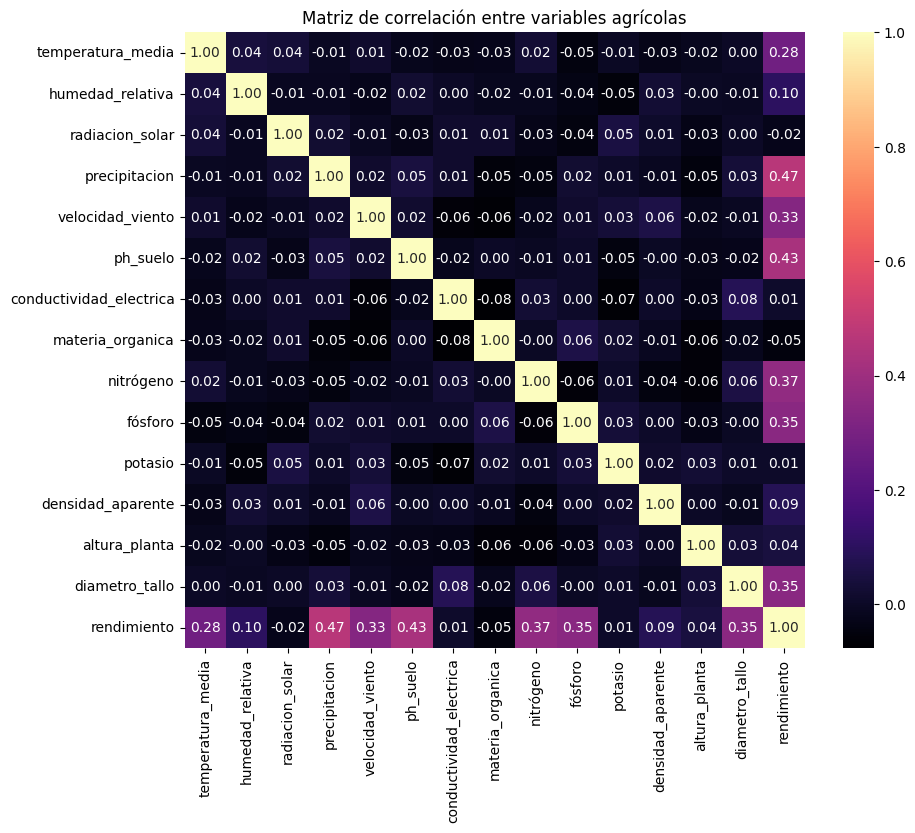

In [ ]:
# Correlación entre variables
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="magma", fmt=".2f")
plt.title("Matriz de correlación entre variables agrícolas")
plt.show()

El análisis de correlación permite identificar qué tan fuertemente se relacionan las variables entre sí y con la variable objetivo (rendimiento).
En este caso, las correlaciones se calcularon utilizando el coeficiente de Pearson, que mide la relación lineal entre pares de variables en un rango de -1 a 1:

*   Valores cercanos a 1: correlación positiva fuerte (ambas variables aumentan juntas).
*   Valores cercanos a -1: correlación negativa fuerte (una variable aumenta mientras la otra disminuye).
*   Valores cercanos a 0: poca o ninguna relación lineal.

En general, las correlaciones entre las variables independientes son muy bajas (entre -0.08 y 0.08), lo que indica baja multicolinealidad. Esto es positivo, ya que cada variable aporta información distinta al modelo.

Las correlaciones más altas con la variable rendimiento son:

*   Precipitación (0.47)
*   ph_suelo (0.43)
*   Nitrógeno (0.37)
*   Fósforo (0.35)
*   Diámetro_tallo (0.35)
*   Velocidad_viento (0.33)
*   Temperatura_media (0.28)

Estas variables parecen tener una influencia más directa sobre el rendimiento simulado.

No se observan correlaciones negativas destacadas, lo que sugiere que el dataset fue generado con relaciones mayoritariamente positivas hacia la variable objetivo. En este caso no exsite una variable dominante ni redundancia excesiva

Este gráfico de heatmap muestra tonos más claros en las variables con mayor correlación con el rendimiento (por ejemplo, precipitacion o ph_suelo).

La diagonal principal (valor = 1) corresponde a la autocorrelación de cada variable consigo misma.

La ausencia de áreas con colores muy saturados entre las variables predictoras confirma la baja colinealidad y la buena calidad del dataset para modelar.

<Figure size 1200x1200 with 0 Axes>

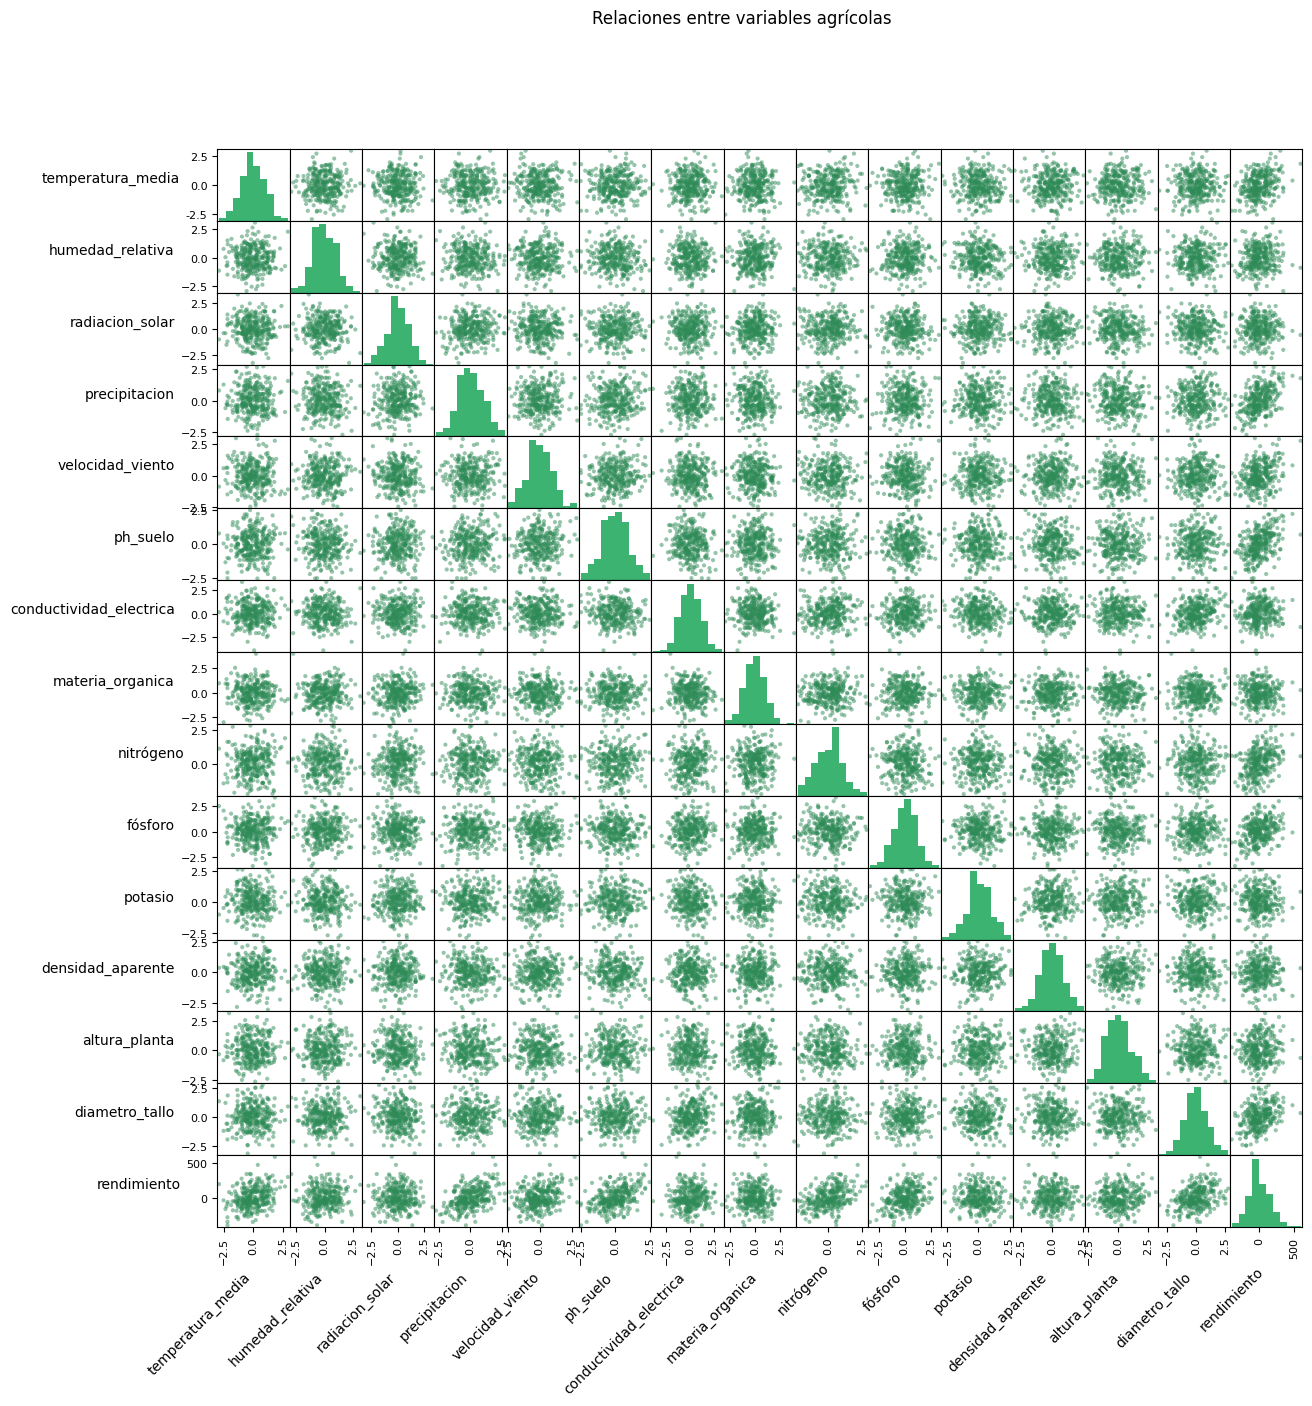

In [ ]:
# Correlación entre variables
plt.figure(figsize=(12, 12))

# Gráfico de matriz de dispersión
axes = scatter_matrix(
    df.sample(300),             # muestra aleatoria de 300 puntos
    alpha=0.5,                  # transparencia de los puntos
    figsize=(14, 14),           # tamaño de la figura
    color='seagreen',           # color de los puntos
    hist_kwds={'color': 'mediumseagreen'},  # color de histogramas diagonales
    diagonal='hist'             # muestra histogramas en la diagonal
)

# Ajustar las etiquetas de ejes
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    ax.xaxis.label.set_ha('right')
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

# Título general
plt.suptitle("Relaciones entre variables agrícolas")

plt.show()

La matriz de dispersión muestra diagramas de dispersión entre pares de variables, y en la diagonal principal la distribución (histograma) de cada una.

En este caso, las nubes de puntos son dispersas y ninguna se asemeja a una línea recta, lo que refuerza la idea de correlaciones bajas entre las variables independientes.

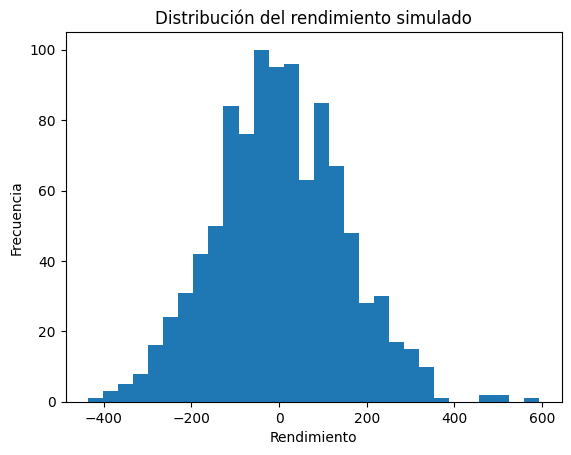

In [ ]:
#Distribución del rendimiento
plt.hist(df["rendimiento"], bins=30)
plt.xlabel("Rendimiento")
plt.ylabel("Frecuencia")
plt.title("Distribución del rendimiento simulado")
plt.show()

Se decide graficar el comportamiento del rendimiento por aparte debido a que es la variable objetivo.
El histograma muestra la forma general de su distribución, que en este caso es aproximadamente normal, centrada cerca de cero.

# **Evaluación de transformaciones**

El propósito de aplicar diferentes técnicas de escalado o normalización es homogeneizar las magnitudes de las variables predictoras.

En este caso se comparan cuatro transformadores:

1.   **StandardScaler**
*    Centra los datos en torno a la media y los escala según la desviación estándar.
*    Mantiene la forma de la distribución original, pero estandariza la magnitud de todas las variables.
*    Es el método más equilibrado para la mayoría de los modelos, especialmente los lineales.
2.   **MinMaxScaler**
*    Escala los datos dentro de un rango entre 0 y 1.
*    Resalta las diferencias relativas entre los valores pequeños y grandes.
*    Puede ser muy sensible a valores atípicos, que pueden comprimir el resto de los datos.
3.   **MaxAbsScaler**
*    Similar al MinMax, pero escala los valores según su valor absoluto máximo, por lo que el rango resultante es [-1, 1].
*   Es útil cuando los datos ya están centrados en torno a 0, como en este caso.
*   No modifica la forma de la distribución, solo ajusta la amplitud.
4. **Normalizer**
*  Escala cada observación (fila) para que tenga una norma unitaria.
*  No se aplica sobre columnas sino sobre registros individuales.
*  Se usa más en métodos basados en distancias, ya que convierte los vectores en direcciones unitarias.

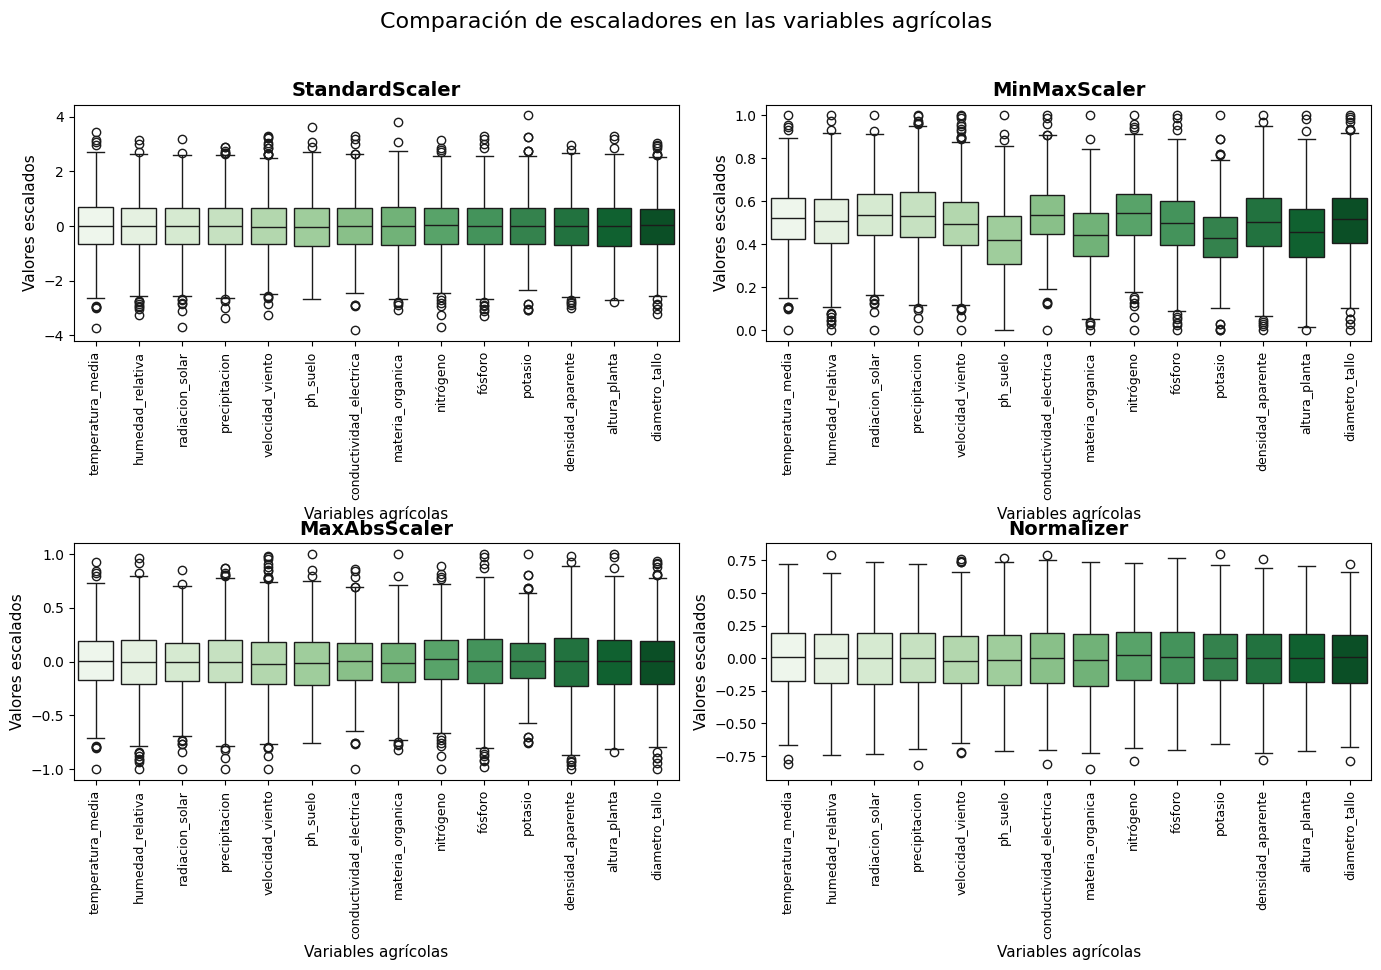

In [ ]:
# Transformaciones
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "MaxAbsScaler": MaxAbsScaler(),
    "Normalizer": Normalizer()
}

X = df.drop("rendimiento", axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, (nombre, scaler) in enumerate(scalers.items()):
    X_scaled = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    sns.boxplot(data=scaled_df, ax=axes[i], palette="Greens")
    axes[i].set_title(nombre, fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Variables agrícolas", fontsize=11)
    axes[i].set_ylabel("Valores escalados", fontsize=11)

    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(9)
        tick.set_ha('center')

plt.suptitle("Comparación de escaladores en las variables agrícolas", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

En los boxplots se observa que StandardScaler produce una distribución más uniforme y simétrica entre las variables, mientras que MinMaxScaler y MaxAbsScaler comprimen los datos dentro de límites estrictos.
Normalizer también es muy uniforme y parece tener menor presencia de atípicos

# **Evaluación del PCA**

El PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad que busca identificar combinaciones lineales de variables que expliquen la mayor parte de la varianza del conjunto de datos.
Esto permite reducir el número de variables conservando la información más relevante.

En este caso el PCA seleccionará el número mínimo de componentes necesarios para retener el 95 % de la varianza total.

Forma original: (1000, 14)
Forma transformada (PCA): (1000, 14)
Varianza explicada: 1.0


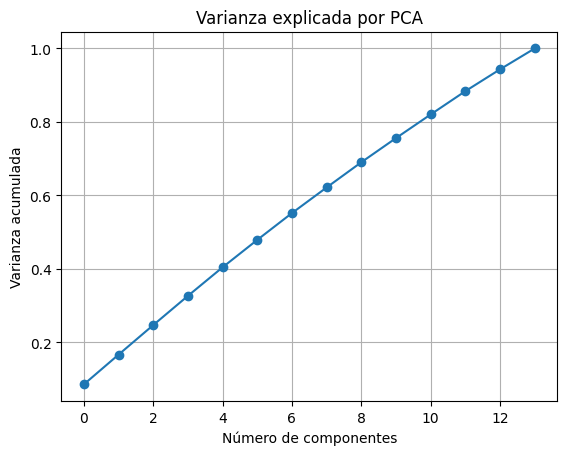

In [ ]:
# Se transforma con StandarScaler porque dio resultados uniformes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Mantener 95% de varianza
X_pca = pca.fit_transform(X_scaled)

print("Forma original:", X_scaled.shape)
print("Forma transformada (PCA):", X_pca.shape)
print("Varianza explicada:", np.sum(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("Varianza explicada por PCA")
plt.grid()
plt.show()

Esto significa que el PCA no eliminó ninguna variable, ya que las 14 componentes principales son necesarias para conservar el 95 % (en este caso, el 100 %) de la varianza total.
El hecho de que el PCA no reduzca la dimensionalidad indica que todas las variables aportan información útil y no redundante.

Las correlaciones entre las variables eran bajas (como se observó antes), lo que implica que no hay combinaciones lineales fuertes que permitan resumir la información en menos componentes.

Por tanto, aplicar PCA no aporta una simplificación del modelo en este caso, y no hay diferencia en si se aplica o no

# **Selección de características**

La selección de características busca identificar las variables más relevantes para predecir el rendimiento y eliminar las que aportan poca información o redundancia.

In [ ]:
# Eliminación por baja varianza
X_scaled = StandardScaler().fit_transform(X)
sel_var = VarianceThreshold(threshold=0.05)
X_lowvar = sel_var.fit_transform(X_scaled)
print("Original:", X.shape, "-> Baja varianza:", X_lowvar.shape)

Original: (1000, 14) -> Baja varianza: (1000, 14)


**VarianceThreshold (eliminación por baja varianza)**

Elimina variables cuya varianza sea inferior a un umbral (en este caso 0.05).

Como todas las variables del dataset tienen varianza similar (~1, debido al StandardScaler), ninguna fue eliminada.

Esto confirma que las variables tienen suficiente variabilidad y no hay columnas constantes.

In [ ]:
# ANOVA
anova = SelectKBest(score_func=f_regression)
X_anova = anova.fit_transform(X_scaled, y)
print("Original:", X.shape,"ANOVA ->", X_anova.shape)
pd.Index(df.drop("rendimiento", axis=1).columns)[anova.get_support()]

Original: (1000, 14) ANOVA -> (1000, 10)


Index(['temperatura_media', 'humedad_relativa', 'precipitacion',
       'velocidad_viento', 'ph_suelo', 'materia_organica', 'nitrógeno',
       'fósforo', 'densidad_aparente', 'diametro_tallo'],
      dtype='object')

**ANOVA (f_regression)**

Calcula la relación estadística entre cada variable y la variable objetivo.
Selecciona las que tienen los mayores valores F, es decir, las más explicativas para el rendimiento.
En este caso, se conservaron 10 de las 14 variables: las que mostraron correlaciones más fuertes con la variable objetivo. En este caso se eliminaron radiacion solar, conductividad electrica, potasio y altura de la planta, porque no mostraron una relación estadísticamente fuerte con el rendimiento.

In [ ]:
# RFE
estimator = LassoCV(cv=3)
rfe = RFE(estimator=estimator)
X_rfe = rfe.fit_transform(X_scaled, y)
print("Original:", X.shape,"RFE ->", X_rfe.shape)
pd.Index(df.drop("rendimiento", axis=1).columns)[rfe.get_support()]

Original: (1000, 14) RFE -> (1000, 7)


Index(['temperatura_media', 'precipitacion', 'velocidad_viento', 'ph_suelo',
       'nitrógeno', 'fósforo', 'diametro_tallo'],
      dtype='object')

**RFE (Recursive Feature Elimination)** con LassoCV

Usa un modelo (Lasso) para estimar la importancia de cada variable y elimina iterativamente las menos relevantes.

Considera la interacción y el peso combinado de las variables dentro del modelo.

En este caso, RFE retuvo 7 variables y eliminó humedad relativa, radiación solar, conductividad electrica, materia orgánica, potasio, densidad aparente y altura de la planta. Es decir, eliminó las mismas de ANOVA y le agregó 3 más a la lista de eliminadas

# **Evaluación de combinaciones de preprocesamiento con modelos con hiperparámetros optimizados**

In [ ]:
X = df.drop("rendimiento", axis=1)
y = df["rendimiento"]

Se separa la variable dependiente (rendimiento) del resto de variables independientes.
X contendrá los predictores y y la variable a predecir.

In [ ]:
# Transformaciones
scalers = {
    "sin_transformar": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "MaxAbsScaler": MaxAbsScaler(),
    "Normalizer": Normalizer()
}

Se definen diferentes métodos de escalado para normalizar o estandarizar los datos antes del modelado.

In [ ]:
# Selección de características
def seleccionar_caracteristicas(X_train, y_train, X_test, metodo):
      """
      Aplica el método de selección especificado: 'Sin selección', 'ANOVA' o 'RFE'.
      RFE usa Lasso como estimador base (para compatibilidad universal).
      """
      if metodo == "Sin selección":
          return X_train.copy(), X_test.copy()

      elif metodo == "ANOVA":
          sel = SelectKBest(score_func=f_regression, k=min(10, X_train.shape[1]))
          X_train_sel = sel.fit_transform(X_train, y_train)
          X_test_sel = sel.transform(X_test)

      elif metodo == "RFE":
          base_estimator = Lasso(alpha=0.01, max_iter=5000, random_state=42)
          sel = RFE(estimator=base_estimator, n_features_to_select=min(10, X_train.shape[1]))
          X_train_sel = sel.fit_transform(X_train, y_train)
          X_test_sel = sel.transform(X_test)

      else:
          raise ValueError("Método de selección no reconocido.")

      return X_train_sel, X_test_sel

Define un procedimiento para reducir el número de variables de entrada según el método elegido.

In [ ]:
# Modelos a evaluar
modelos = {
    "LassoCV": LassoCV(max_iter=5000, random_state=42),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(max_iter=1000, random_state=42)
  }

def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
  modelo.fit(X_train, y_train)
  pred = modelo.predict(X_test)
  return {
      "R2": r2_score(y_test, pred),
      "MAE": mean_absolute_error(y_test, pred),
      "RMSE": np.sqrt(mean_squared_error(y_test, pred))
      }

Se definen tres modelos de aprendizaje supervisado clásicos, representativos de distintos enfoques:

*  LassoCV: regresión lineal regularizada, con selección automática del parámetro α.
*  KNN: modelo basado en vecinos más cercanos, sensible a la escala.
*  MLP: red neuronal multicapa (modelo no lineal).

In [ ]:
# Ejecución de experimentos
resultados = []

for nombre_scaler, scaler in scalers.items():
    # División del dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Transformación
    if scaler:
        X_train_proc = scaler.fit_transform(X_train)
        X_test_proc = scaler.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train.values, X_test.values

    # Selector
    for metodo_sel in ["Sin selección", "ANOVA", "RFE"]:
        X_train_sel, X_test_sel = seleccionar_caracteristicas(
            X_train_proc, y_train, X_test_proc, metodo_sel
        )
        for nombre_modelo, modelo in modelos.items():
            print(f"Ejecutando: {nombre_scaler} | {metodo_sel} | {nombre_modelo}")  # Control visual
            # Base
            base = evaluar_modelo(modelo, X_train_sel, X_test_sel, y_train, y_test)
            resultados.append({
                "Scaler": nombre_scaler,
                "Selector": metodo_sel,
                "Modelo": nombre_modelo,
                "Metodo": "Base",
                **base
            })

            # Cross Validation
            modelo_cv = modelo
            modelo_cv.fit(X_train_sel, y_train)
            y_pred_cv = modelo_cv.predict(X_test_sel)

            R2_cv = r2_score(y_test, y_pred_cv)
            MAE_cv = mean_absolute_error(y_test, y_pred_cv)
            RMSE_cv = np.sqrt(mean_squared_error(y_test, y_pred_cv))

            resultados.append({
                "Scaler": nombre_scaler,
                "Selector": metodo_sel,
                "Modelo": nombre_modelo,
                "Metodo": "CrossVal",
                "R2": R2_cv,
                "MAE": MAE_cv,
                "RMSE": RMSE_cv
            })

            # GridSearch
            if nombre_modelo == "LassoCV":
                param_grid = {"alphas": [np.logspace(-3, 1, 10)]}
            elif nombre_modelo == "KNN":
                param_grid = {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
            elif nombre_modelo == "MLP":
                param_grid = {
                    "hidden_layer_sizes": [(50,), (100,), (100, 50)],
                    "learning_rate_init": [0.001, 0.01],
                    "activation": ["relu", "tanh"]
                }
            else:
              param_grid = {}

            grid = GridSearchCV(modelo, param_grid, cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train_sel, y_train)
            best = grid.best_estimator_

            met_grid = evaluar_modelo(best, X_train_sel, X_test_sel, y_train, y_test)
            resultados.append({
                "Scaler": nombre_scaler,
                "Selector": metodo_sel,
                "Modelo": nombre_modelo,
                "Metodo": "GridSearch",
                **met_grid
            })

Ejecutando: sin_transformar | Sin selección | LassoCV
Ejecutando: sin_transformar | Sin selección | KNN
Ejecutando: sin_transformar | Sin selección | MLP
Ejecutando: sin_transformar | ANOVA | LassoCV
Ejecutando: sin_transformar | ANOVA | KNN
Ejecutando: sin_transformar | ANOVA | MLP
Ejecutando: sin_transformar | RFE | LassoCV
Ejecutando: sin_transformar | RFE | KNN
Ejecutando: sin_transformar | RFE | MLP
Ejecutando: StandardScaler | Sin selección | LassoCV
Ejecutando: StandardScaler | Sin selección | KNN
Ejecutando: StandardScaler | Sin selección | MLP
Ejecutando: StandardScaler | ANOVA | LassoCV
Ejecutando: StandardScaler | ANOVA | KNN
Ejecutando: StandardScaler | ANOVA | MLP
Ejecutando: StandardScaler | RFE | LassoCV
Ejecutando: StandardScaler | RFE | KNN
Ejecutando: StandardScaler | RFE | MLP
Ejecutando: MinMaxScaler | Sin selección | LassoCV
Ejecutando: MinMaxScaler | Sin selección | KNN
Ejecutando: MinMaxScaler | Sin selección | MLP
Ejecutando: MinMaxScaler | ANOVA | LassoCV
Ejecu

Corre el código haciendo todas las posibles combinaciones entre las transformaciones, los selectores, los modelos y tres variantes de busqueda de hiperpaármetros:
1. Base: entrenamiento simple con datos de prueba.
2. Cross Validation: validación cruzada con los mismos datos de entrenamiento.
3. GridSearch: búsqueda de hiperparámetros óptimos según el modelo.

Y calcula las métricas principales de desempeño:

*  R2: capacidad explicativa del modelo (se busca que sea cercano a 1).
*  MAE: error medio absoluto (se busca que sea lo menor posible).
*  RMSE: raíz del error cuadrático medio (se busca que sea lo menor posible).

In [ ]:
# Resultados
resultados_df = pd.DataFrame(resultados)
print("\n=== Resultados consolidados ===")
display(resultados_df.head())
#  Guardar los resultados completos
resultados_df.to_csv("resultados_modelos.csv", index=False, encoding='utf-8-sig')
print("Archivo 'resultados_modelos.csv' guardado correctamente.")


=== Resultados consolidados ===


,Scaler,Selector,Modelo,Metodo,R2,MAE,RMSE
0,sin_transformar,Sin selección,LassoCV,Base,0.99,10.13,12.45
1,sin_transformar,Sin selección,LassoCV,CrossVal,0.99,10.13,12.45
2,sin_transformar,Sin selección,LassoCV,GridSearch,0.99,10.12,12.44
3,sin_transformar,Sin selección,KNN,Base,0.67,61.59,80.47
4,sin_transformar,Sin selección,KNN,CrossVal,0.67,61.59,80.47


Archivo 'resultados_modelos.csv' guardado correctamente.


In [ ]:
# Resumen general ordenado
resumen_df = (
    resultados_df
    .groupby(["Scaler", "Selector", "Modelo", "Metodo"])["R2"]
    .mean()
    .reset_index()
)

# Ordenar por R2 de mayor a menor
resumen_ordenado = resumen_df.sort_values(by="R2", ascending=False)

print("\n 10 mejores combinaciones según R2 promedio")
print(resumen_ordenado.head(10))

print("\n10 peores combinaciones según R2 promedio")
print(resumen_ordenado.tail(10))


 10 mejores combinaciones según R2 promedio
              Scaler       Selector   Modelo      Metodo   R2
131  sin_transformar  Sin selección  LassoCV  GridSearch 0.99
23      MaxAbsScaler  Sin selección  LassoCV  GridSearch 0.99
130  sin_transformar  Sin selección  LassoCV    CrossVal 0.99
129  sin_transformar  Sin selección  LassoCV        Base 0.99
102   StandardScaler  Sin selección  LassoCV        Base 0.99
103   StandardScaler  Sin selección  LassoCV    CrossVal 0.99
50      MinMaxScaler  Sin selección  LassoCV  GridSearch 0.99
49      MinMaxScaler  Sin selección  LassoCV    CrossVal 0.99
48      MinMaxScaler  Sin selección  LassoCV        Base 0.99
22      MaxAbsScaler  Sin selección  LassoCV    CrossVal 0.99

10 peores combinaciones según R2 promedio
              Scaler       Selector Modelo      Metodo   R2
18      MaxAbsScaler  Sin selección    KNN        Base 0.70
47      MinMaxScaler  Sin selección    KNN  GridSearch 0.70
101   StandardScaler  Sin selección    KNN  GridSe

# **Visualización de resultados con el grupo de prueba**

Text(0.5, 1.0, 'R² por modelo y método')

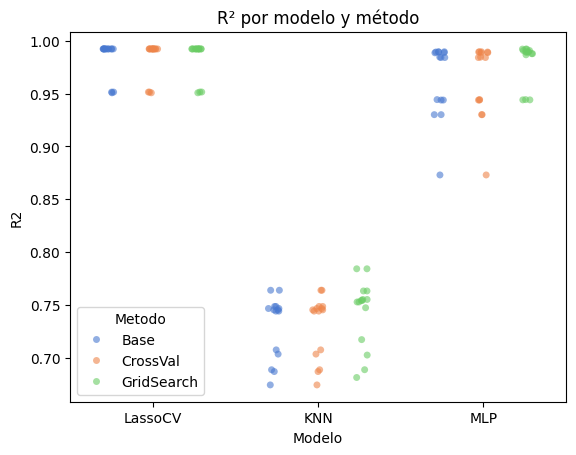

In [ ]:
# Strip Plot/Gráfico de puntos
sns.stripplot(data=resultados_df, x="Modelo", y="R2", hue="Metodo", dodge=True, palette="muted", alpha=0.6)
plt.title("R² por modelo y método")

Ese gráfico está mostrando la distribución de los valores de R² para cada modelo, diferenciando por el método de evaluación (Base, CrossVal, GridSearch).

Eje X: muestra los tres modelos (LassoCV, KNN, MLP).

Eje Y: muestra los valores de desempeño (R²).

Color: indica el método usado (Base, CrossVal, GridSearch).

Cada punto: es un resultado de una combinación específica de escalador y selector.

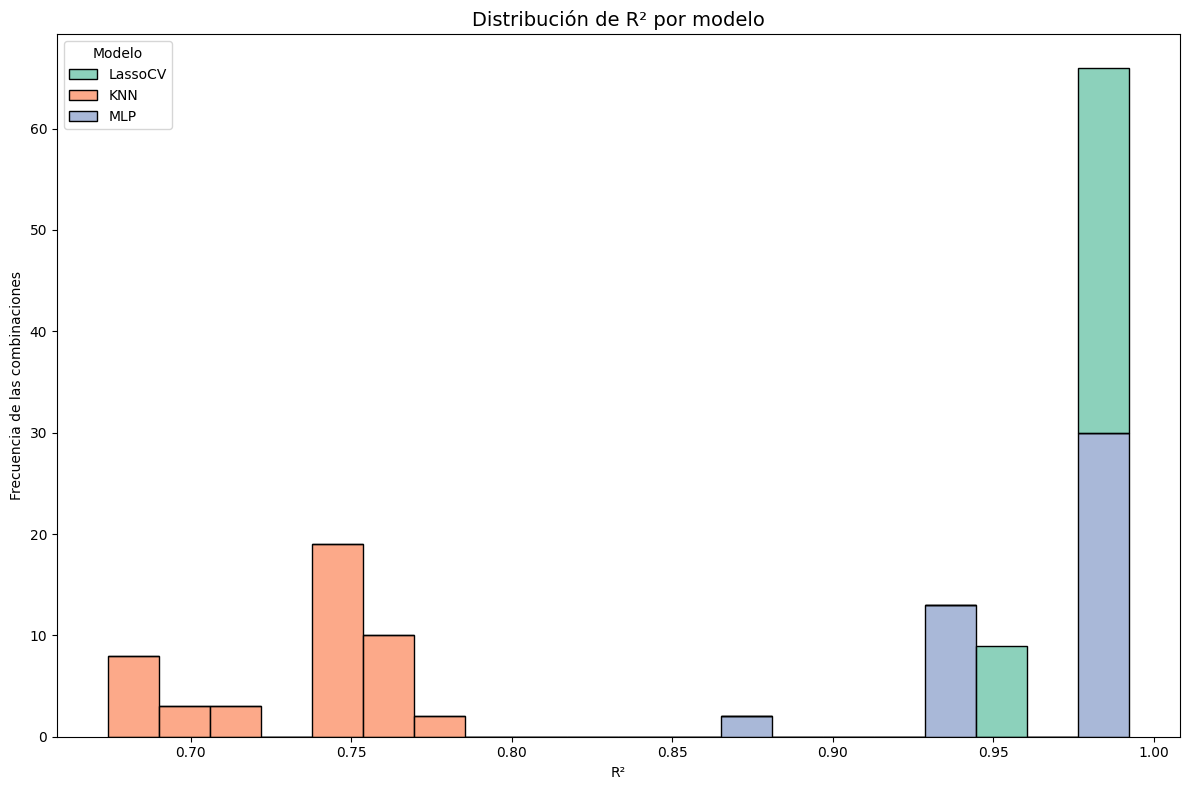

In [ ]:
# Histograma apilado
plt.figure(figsize=(12,8))
sns.histplot(
    data=resultados_df,
    x="R2", hue="Modelo",
    multiple="stack",
    palette="Set2", bins=20
)
plt.title("Distribución de R² por modelo", fontsize=14)
plt.xlabel("R²")
plt.ylabel("Frecuencia de las combinaciones")
plt.tight_layout()
plt.show()

Permite observar cómo se distribuyen los valores de R² obtenidos por cada modelo a lo largo de todas las combinaciones de preprocesamiento y selección de variables.

Text(0.5, 1.0, 'Evolución del R² promedio según escalador')

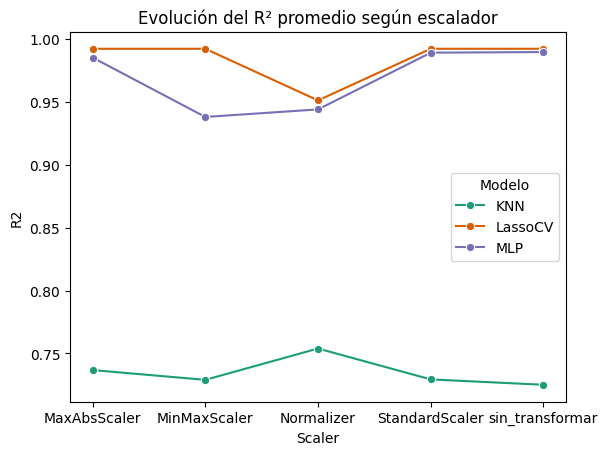

In [ ]:
# Gráfico de líneas
resumen = resultados_df.groupby(["Scaler", "Modelo"])["R2"].mean().reset_index()
sns.lineplot(data=resumen, x="Scaler", y="R2", hue="Modelo", marker="o", palette="Dark2")
plt.title("Evolución del R² promedio según escalador")

Se observa cómo varía el desempeño promedio (R²) de cada modelo según el tipo de escalador aplicado en el preprocesamiento.

Si una línea se mantiene alta y estable, significa que el modelo es robusto frente a las transformaciones.

Si una línea varía mucho, indica que su desempeño depende fuertemente del tipo de escalado.

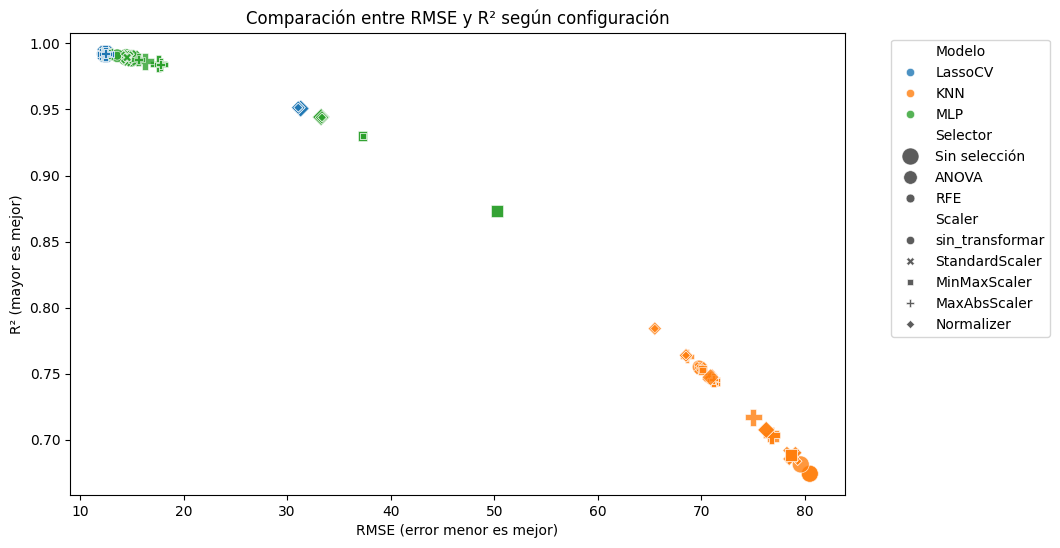

In [ ]:
# Scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=resultados_df,
    x="RMSE", y="R2",
    hue="Modelo", style="Scaler",
    size="Selector", sizes=(40,150),
    alpha=0.8
)
plt.title("Comparación entre RMSE y R² según configuración")
plt.xlabel("RMSE (error menor es mejor)")
plt.ylabel("R² (mayor es mejor)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Permite observar la relación entre precisión y error para todas las combinaciones de modelos, escaladores y métodos de selección.
Puntos más arriba y a la izquierda representan mejor desempeño global (mayor R² y menor RMSE).

* Agrupamientos de color indican si un modelo tiende a comportarse consistentemente bien.

Por ejemplo, en este caso, los puntos del color asociado a LassoCV están concentrados en la zona superior izquierda, lo que es una señal de alta estabilidad y precisión.

* Formas (por tipo de escalador) permiten ver qué transformaciones favorecen el desempeño.

* Tamaños (por selector de características) muestran si la selección mejora o no el rendimiento.

Text(0.5, 1.02, 'Relaciones entre métricas de evaluación')

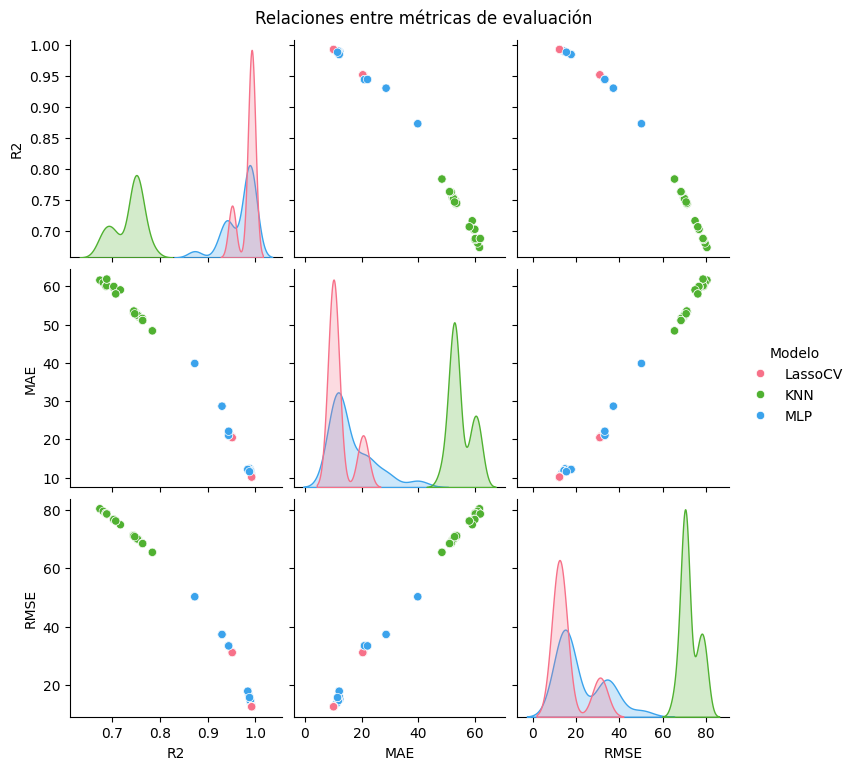

In [ ]:
# Pairplot
sns.pairplot(resultados_df[["R2", "MAE", "RMSE", "Modelo"]], hue="Modelo", diag_kind="kde", palette="husl")
plt.suptitle("Relaciones entre métricas de evaluación", y=1.02)

Se pueden visualizar relaciones entre las métricas de evaluación y detectar patrones o inconsistencias en el desempeño de los modelos.
* Una relación negativa entre RMSE y R² (los puntos tienden hacia una diagonal descendente) indica que a menor error, mayor capacidad explicativa del modelo.
* Una relación positiva entre RMSE y MAE muestra coherencia entre ambas medidas de error (si una baja, la otra también).
* Muestra qué modelos se destacan o se diferencian claramente en sus resultados.En este caso tanto Lasso como MLP muestran comportamientos muy similares con alta precisión, mientras KNN tiene menor precisión según las métricas evaluadas

Es útil para comprobar si las métricas están coherentemente relacionadas (evitando interpretaciones contradictorias).

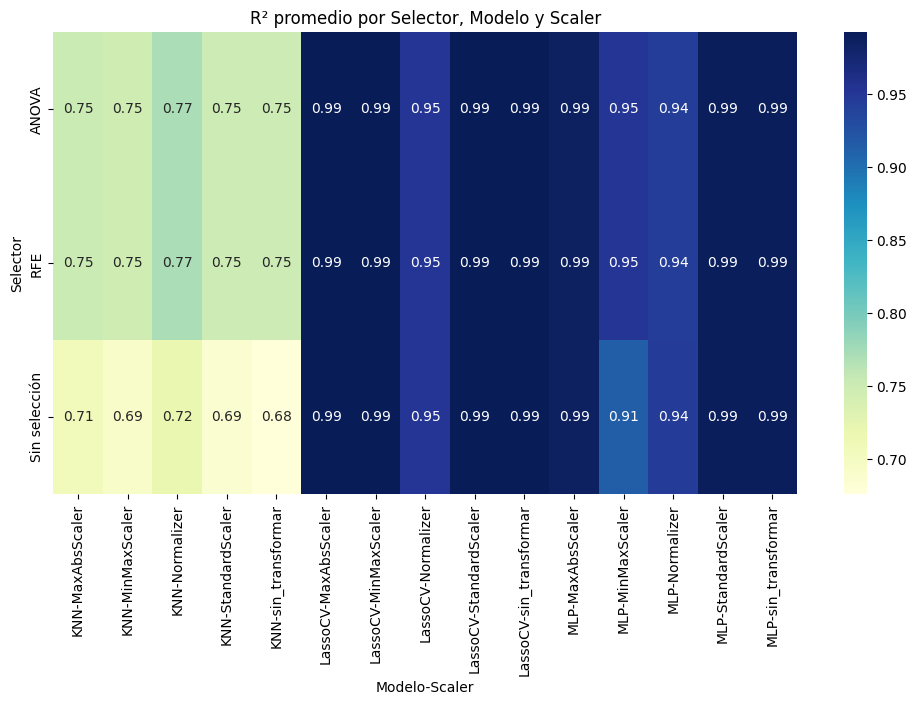

In [ ]:
# Heatmap
pivot = resultados_df.pivot_table(
    values="R2", index=["Selector"], columns=["Modelo", "Scaler"], aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("R² promedio por Selector, Modelo y Scaler")
plt.show()

Se observa un heatmap (mapa de calor) que resume, de forma visual, cómo varía el R² promedio en función de los métodos de selección de características, los modelos, y los escaladores aplicados.

Las filas (Selector) indican el método de selección de características.

Las columnas combinan los modelos y escaladores aplicados.

El color de cada celda refleja el valor del R² promedio:

Tonos más oscuros → mayor R², mejor desempeño.

Tonos claros → menor R², peor desempeño.

Los valores dentro de las celdas te permiten comparar cuantitativamente qué combinación fue más eficiente. En este caso, todas las combinaciones de Lasso exceptuando la normalización y las combinaciones de MLP sin MinMaxScaler y Normalización dieron el valor más alto con 0.99 de R^2 promedio

### **Conclusión:** Los resultados muestran una consistencia notable en las métricas, especialmente en los modelos LassoCV y MLP con la mayoría de escaladores, con valores de R² superiores a 0.98 y errores bajos (MAE entre 10 y 12). En contraste, el modelo KNN tuvo un desempeño considerablemente inferior (R² entre 0.67 y 0.76), mostrando su alta sensibilidad a la escala y distribución de los datos